## Houses prices prediction
#### Attempt some feature engineering and outlier removal

In [1]:
import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
# read the data

train = pd.read_csv('data/train.csv', index_col=['Id'])
test = pd.read_csv('data/test.csv', index_col=['Id'])

In [3]:
# Check target label

train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [4]:
# Check numeric features
numeric_features = train.select_dtypes(include=[pd.np.number])
print(numeric_features.dtypes)

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object


SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


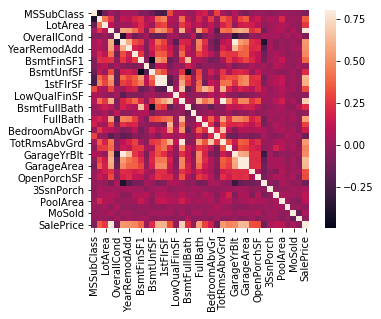

In [5]:
# Check correlation betwen target label and the numeric columns

corr = numeric_features.corr()
print (corr['SalePrice'].sort_values(ascending=False)[:5])
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

sns.heatmap(corr, vmax=.8, square=True);

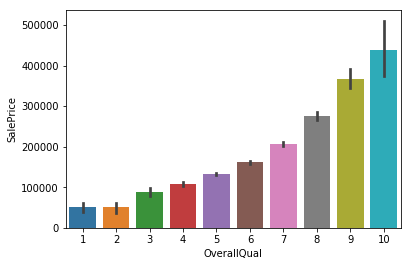

In [6]:
# Check how to quality affects the saleprice

sns.barplot(x='OverallQual', y='SalePrice', data=train);

In [7]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:19])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageCond,81
GarageFinish,81


In [8]:
categoricals = train.select_dtypes(include=[pd.np.object])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


### The bottom cell will visualize the relationships between SalePrice and the rest of the columns

In [9]:
# Run this if you have enough memory
plt.rcParams.update({'figure.max_open_warning': 50})

# for i, c in enumerate(categoricals):
#     plt.figure(i)
#     sns.barplot(x=c, y='SalePrice', data=train);

### Candidates for separate feature, who have high relationships with SalePrice are:
* SaleCondition - Partial
* MiscFeature - TenC
* FireplaceQu - Ex
* Electrical - SBrkr
* RoofMatl - WdShngl

In [10]:
# Let's see what happenes when we make a new feature
# results - 0.00001 improvement

def encode(x): return 1 if x == 'Partial' else 0
train['enc_condition'] = train.SaleCondition.apply(encode)
train = train.drop(labels=['SaleCondition'], axis=1)

In [11]:
# Let's see what happenes when we make a new feature
# results - 0.000001 improvement

def encode(x): return 1 if x == 'TenC' else 0
train['enc_misc'] = train.MiscFeature.apply(encode)
train = train.drop(labels=['MiscFeature'], axis=1)

In [12]:
# Let's see what happenes when we make a new feature
# results - 0.0001 improvement

def encode(x): return 1 if x == 'Ex' else 0
train['enc_fireplace'] = train.FireplaceQu.apply(encode)
train = train.drop(labels=['FireplaceQu'], axis=1)

In [13]:
# Let's see what happenes when we make a new feature
# results - 0.001 improvement

def encode(x): return 1 if x == 'SBrkr' else 0
train['enc_elec'] = train.Electrical.apply(encode)
train = train.drop(labels=['Electrical'], axis=1)

In [14]:
# Let's see what happenes when we make a new feature
# results - 0.0015 improvement

def encode(x): return 1 if x == 'WdShngl' else 0
train['enc_roof'] = train.RoofMatl.apply(encode)
train = train.drop(labels=['RoofMatl'], axis=1)

### Identify and remove outliers
#### The commented code will draw scatter plots between SalePrice and all other columns

In [15]:
# for i, n in enumerate(numeric_features.columns):
#     print(n)
#     plt.figure(i)
#     plt.scatter(x=train[n], y=train['SalePrice'])
#     plt.ylabel('Sale Price')
#     plt.xlabel(n)
#     plt.show()

def clear_outliers(data):
    data = data[data['LotArea'] < 100000]
    data = data[data['BsmtFinSF1'] < 1800]
    data = data[data['BsmtFinSF2'] < 1200]
    data = data[data['TotalBsmtSF'] < 2500]
    
    return data

train = clear_outliers(train)

In [16]:
from sklearn.model_selection import train_test_split

def split_data_by(data, target):

    # split the dataset to with and without labels
    train_no_sale_price = data.drop(labels=[target], axis=1)
    train_sale_price = data[target]

    # split the train set to 70/30 train/test
    return train_test_split(train_no_sale_price, 
                            train_sale_price, 
                            test_size=0.3, 
                            random_state=4330)

x_train, x_test, y_train, y_test = split_data_by(train, 'SalePrice')
# Make sure correct data fell int the correct variables
for df in [x_train, x_test, y_train, y_test]:
    print(df.shape)

(1010, 79)
(433, 79)
(1010,)
(433,)


In [17]:
# Handle null values
numeric_columns = x_train.select_dtypes(include=[pd.np.number]).columns
x_train[numeric_columns] = x_train[numeric_columns].fillna(0)
x_test[numeric_columns] = x_test[numeric_columns].fillna(0)

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def encode_categorical(data, columns, encoders):
    data = data.fillna("")
    return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns},
                        index = data.index)

In [19]:
categorical_columns = x_train.select_dtypes(include=[pd.np.object]).columns
train = train.fillna("")
encoders = {col: LabelEncoder().fit(train[col]) for col in categorical_columns}


train_encoded = encode_categorical(train, categorical_columns, encoders)

one_hot_encoder = OneHotEncoder().fit(train_encoded)
one_hot_x_train = one_hot_encoder.transform(encode_categorical(x_train[categorical_columns], categorical_columns, encoders))
one_hot_x_test = one_hot_encoder.transform(encode_categorical(x_test[categorical_columns], categorical_columns, encoders))

In [20]:
new_x_train = pd.np.concatenate([one_hot_x_train.todense(), x_train[numeric_columns]], axis=1)
new_x_test = pd.np.concatenate([one_hot_x_test.todense(), x_test[numeric_columns]], axis=1)

### The bottom cell is giving the weird values we were talking about in the slack channel

In [21]:
# from sklearn.linear_model import LinearRegression
# lr = LinearRegression().fit(new_x_train, y_train)
# lr.score(new_x_test, y_test)


### Check how data is skewed

1.6696605533259425 0.04948892365856159


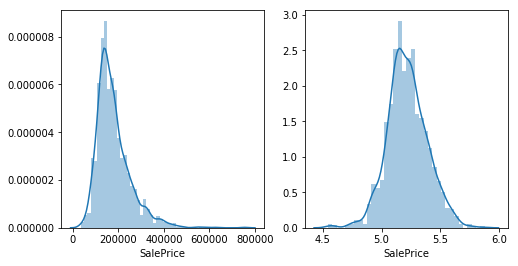

In [23]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.distplot(train['SalePrice'])
plt.subplot(1, 2, 2)
sns.distplot(pd.np.log10(train['SalePrice']))

print(train.SalePrice.skew(), pd.np.log10(train['SalePrice']).skew())

### I found Ridge to give the best results of the linear algorithms

In [24]:
# regularization
from sklearn.linear_model import Ridge

alpha = [0.01, 0.1, 1, 10, 100]

for a in alpha:
    all_data_lr = Ridge(alpha = a).fit(new_x_train, y_train)
    print('alpha:', a)
    print(all_data_lr.score(new_x_train, y_train), all_data_lr.score(new_x_test, y_test))
    print()

alpha: 0.01
0.9423401636947232 0.8898012448940393

alpha: 0.1
0.9421859462413315 0.8919960480999863

alpha: 1
0.9404488551520288 0.8983901551175418

alpha: 10
0.9335917568976061 0.9049612512482914

alpha: 100
0.9138141222777566 0.8995291233570234



In [25]:
# try with log10

for a in alpha:
    all_data_lr = Ridge(alpha = a).fit(new_x_train, pd.np.log10(y_train))
    print('alpha:', a)
    print(all_data_lr.score(new_x_train, pd.np.log10(y_train)), all_data_lr.score(new_x_test, pd.np.log10(y_test)))
    print()

alpha: 0.01
0.9466239333091557 0.9069865194122935

alpha: 0.1
0.9464824193458047 0.9098514023819393

alpha: 1
0.9444714372465681 0.9207627255646759

alpha: 10
0.9344372027621587 0.9314846967081457

alpha: 100
0.9165750263469484 0.9296886054060456



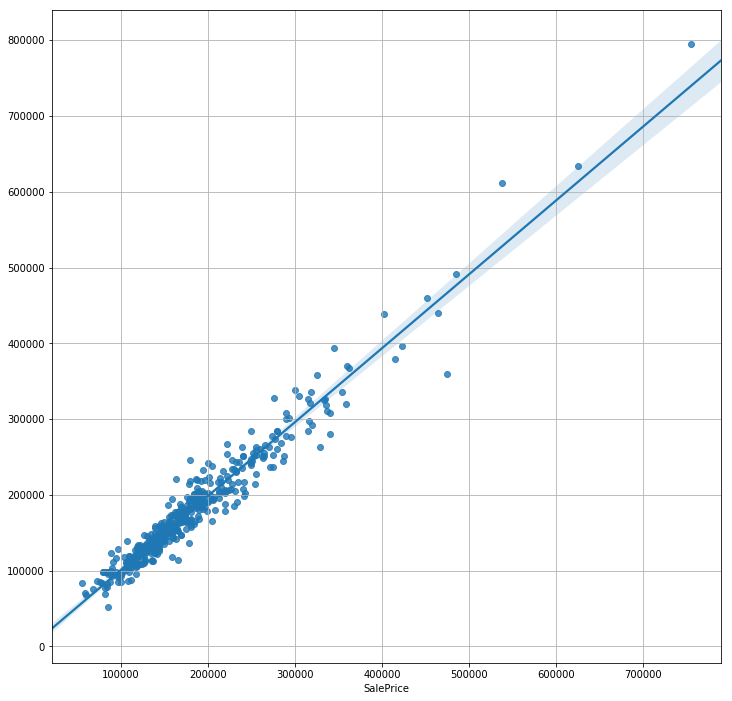

In [26]:
lr = Ridge(10).fit(new_x_train, pd.np.log10(y_train))
predictions = 10 ** lr.predict(new_x_test)

plt.figure(figsize=(12,12))
sns.regplot(y_test, predictions)
plt.grid(True)
plt.show()

### Score with Ridge and alpha = 10:
### Train: 0.9344
### Test:  0.9315

### The next step I'd take is to create separate models to predict the missing null values, but I found it to take too mich time and I couldn't fit it in my time window.

In [35]:
def create_features(train):
    def encode(x): return 1 if x == 'Partial' else 0
    train['enc_condition'] = train.SaleCondition.apply(encode)
    train = train.drop(labels=['SaleCondition'], axis=1)

    def encode(x): return 1 if x == 'TenC' else 0
    train['enc_misc'] = train.MiscFeature.apply(encode)
    train = train.drop(labels=['MiscFeature'], axis=1)
    
    def encode(x): return 1 if x == 'Ex' else 0
    train['enc_fireplace'] = train.FireplaceQu.apply(encode)
    train = train.drop(labels=['FireplaceQu'], axis=1)
    
    def encode(x): return 1 if x == 'SBrkr' else 0
    train['enc_elec'] = train.Electrical.apply(encode)
    train = train.drop(labels=['Electrical'], axis=1)
    
    def encode(x): return 1 if x == 'WdShngl' else 0
    train['enc_roof'] = train.RoofMatl.apply(encode)
    train = train.drop(labels=['RoofMatl'], axis=1)
    
    return train

In [74]:
# Model submission
train = pd.read_csv('data/train.csv', index_col=['Id'])
test = pd.read_csv('data/test.csv', index_col=['Id'])

def pipeline_data(data):
    data = create_features(data)
    _numeric = data[numeric_columns].fillna(0)
    _categorical = data[categorical_columns].fillna("") 
    _encoded = encode_categorical(_categorical, categorical_columns, encoders)
    _one_hot_encoded = one_hot_encoder.transform(_encoded)
    _merged = pd.np.concatenate([_one_hot_encoded.todense(), _numeric], axis=1)
    return _merged

In [75]:
train = clear_outliers(train)

full_x = pipeline_data(train)
full_y = train['SalePrice']

# Fix test set missing data problems
test['MSZoning'].fillna('RL', inplace=True)
test['Utilities'].fillna('AllPub', inplace=True)
test['Exterior1st'].fillna('VinylSd', inplace=True)
test['Exterior2nd'].fillna('VinylSd', inplace=True)
test['KitchenQual'].fillna('TA', inplace=True)
test['Functional'].fillna('Typ', inplace=True)
test['SaleType'].fillna('WD', inplace=True)

test_set = pipeline_data(test)

print (full_x.shape, full_y.shape)

(1443, 278) (1443,)


In [76]:
ridge = Ridge(alpha=10).fit(full_x, pd.np.log10(full_y))
predictions = 10**ridge.predict(test_set)
print(test_set.shape, test.index.shape, predictions.shape)

(1459, 278) (1459,) (1459,)


In [77]:
predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})
predictions_df.to_csv("submit_me.csv", index=False)
predictions_df.head()

,Id,SalePrice
0,1461,114265.240275
1,1462,152130.007205
2,1463,181483.357426
3,1464,196949.646922
4,1465,193520.801687


### 926 място в Kaggle